# Import libary

In [1]:
import sasktran as sk
import numpy as np
import datetime as dt
import time as T
import cv2
from joblib import Parallel, delayed
import numba as nb
import os
import paramiko
from scp import SCPClient
import subprocess
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.transforms as mtransforms

# Function

In [2]:
class AHI_angle:
    def __init__(self,date,):
        self.date = date      
        
    def read_angle_data(self):
    
        AHI_date = self.date[4:11]
        
        sza_file_name = 'AHI_SZA_2018{}5.dat'.format(AHI_date)
        saa_file_name = 'AHI_SAA_2018{}5.dat'.format(AHI_date)
        
        with open(SZA_PATH + sza_file_name,'rb') as fp:
            AHI_SZA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000) / 100
            AHI_SZA=cv2.resize(np.array(AHI_SZA,dtype='float64'),(12000,12000),interpolation=cv2.INTER_NEAREST)
        
        with open(SAA_PATH + saa_file_name,'rb') as fp:
            AHI_SAA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000) / 100
            AHI_SAA=cv2.resize(np.array(AHI_SAA,dtype='float64'),(12000,12000),interpolation=cv2.INTER_NEAREST)        
        return AHI_SZA,AHI_SAA
class H8_data:

    def __init__(self , account , pw , band , band_number , date):
        self.account = account
        self.pw = pw
        self.band = band
        self.band_number = band_number
        self.date = date
    
    def get_path(self):
        return '/data01/GEO/ORGDATA/H8AHI/hmwr829gr.cr.chiba-u.ac.jp/gridded/FD/V20151105/' + self.date[0:6] + '/' + self.band.upper() + '/'

    def get_filename(self):
        return self.date + "." + self.band + "." + self.band_number + ".fld.geoss.bz2"
    
    def DN2TBB(self,data):
        LUT=np.loadtxt(DN_PATH + 'count2tbb_v102/' + self.band + "." + self.band_number)
        return LUT[data,1]
    
    def file_path(self):
        return self.get_path() + self.get_filename() 
                 
    def download_H8data(self):
        client = paramiko.SSHClient()
        client.load_system_host_keys()
        client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        client.connect(hostname='10.4.123.47', port=22, username=self.account, password=self.pw)
        scp = SCPClient(client.get_transport())
        sftp = client.open_sftp()

        try :
            sftp.stat(self.file_path())

        except FileNotFoundError:
            print("File Not Found")
            return 'No data'

        else:
            scp.get(self.file_path(), folder_original+'/')
            p = subprocess.Popen('lbzip2 -d {}{}'.format(folder_original+'/',self.file_path()[-33:]),shell=True)
            p.communicate()
            print ('Himawari8/AHI data Processed Finish')
            return folder_original + '/' + self.get_filename()[:-4]
            
    def read_H8data(self):
        H8_file_path = self.download_H8data()
        if self.band == "vis":
            sr = 12000
        elif self.band == "ext":
            sr = 24000
        else:
            sr = 6000
        if H8_file_path != 'No data':
            with open(H8_file_path,'rb') as fp:
                data = np.frombuffer(fp.read(),dtype='>u2').reshape(sr,sr)
                data = self.DN2TBB(data)
                data = data/100

            print("data reading finish")
            return data
        else:
            return 'No data'
        

In [3]:
def Time_split(time):
    YYYY = time.strftime('%Y')
    MM = time.strftime('%m')
    DD = time.strftime('%d')
    HH = time.strftime('%H')
    MIN = time.strftime('%M')
    date = YYYY + MM + DD + HH + MIN
    return YYYY,MM,DD,HH,MIN,date

def time2mjd(dateT):
    t0=dt.datetime(1858,11,17,0,0,0,0)
    mjd=(dateT-t0).days
    mjd_s=dateT.hour*3600.0+dateT.minute*60.0+dateT.second+dateT.microsecond/1000000.0
    return mjd+mjd_s/86400.0

def Get_Kernel_Input_Parameter(date,band):
    AHI_SZA,AHI_SAA = AHI_angle(date).read_angle_data()
    RAA = abs(AHI_SAA - VAA)
    RAA[RAA>180]=360-RAA[RAA>180]
    if band == 4:
        if os.path.exists(SR_PATH + '{}_AC/{}_b04.dat'.format(date,date)):
            with open(SR_PATH + '{}_AC/{}_b04.dat'.format(date,date),'rb') as fp:
                SR = np.frombuffer(fp.read(),dtype='f4').reshape(12000,12000)
        else:
            return 'None','None','None'
    if band == 3:
        if os.path.exists(SR_PATH + '{}_AC/{}_b03.dat'.format(date,date)):
            with open(SR_PATH + '{}_AC/{}_b03.dat'.format(date,date),'rb') as fp:
                SR = np.frombuffer(fp.read(),dtype='f4').reshape(24000,24000)
                SR = SR.reshape(12000,2,12000,2).mean(-1).mean(1)
        else:
            return 'None','None','None'
    # return SR[AHI_row-6:AHI_row+6,AHI_col-6:AHI_col+6],RAA[AHI_row-6:AHI_row+6,AHI_col-6:AHI_col+6],AHI_SZA[AHI_row-6:AHI_row+6,AHI_col-6:AHI_col+6]
    return SR[2550:2750,4700:5000],RAA[2550:2750,4700:5000],AHI_SZA[2550:2750,4700:5000]

def Volume_Kernel(wavel_nm,latitude,longitude,mjd,Cos_SZA,Cos_VZA,Cos_RAA):
    brdf = sk.RossThickKernel()
    vol = brdf.reflectance(wavel_nm,latitude,longitude,mjd,Cos_SZA,Cos_VZA,Cos_RAA)
    return vol

def Geometric_Kernel(wavel_nm,latitude,longitude,mjd,Cos_SZA,Cos_VZA,Cos_RAA):
    brdf = sk.LiSparseReciprocalKernel(crown_shape=1.0, relative_height=2.0)
    geo = brdf.reflectance(wavel_nm,latitude,longitude,mjd,Cos_SZA,Cos_VZA,Cos_RAA)
    return geo



def MODIS_Kernel_BRDF(band,idx_row,idx_col): 
    if band == 3:
        if c_o_mask[idx_row,idx_col] == True:
            kvol = Volume_Kernel(640,lat[idx_row],lon[idx_col],MJD,np.cos(np.radians(SZA[idx_row,idx_col])),np.cos(np.radians(VZA[idx_row,idx_col])),np.cos(np.radians(RAA[idx_row,idx_col])))
            kgeo = Geometric_Kernel(640,lat[idx_row],lon[idx_col],MJD,np.cos(np.radians(SZA[idx_row,idx_col])),np.cos(np.radians(VZA[idx_row,idx_col])),np.cos(np.radians(RAA[idx_row,idx_col])))
            return kvol,kgeo
        else:
            return np.nan,np.nan
    elif band == 4:
        if c_o_mask[idx_row,idx_col] == True:
            kvol = Volume_Kernel(860,lat[idx_row],lon[idx_col],MJD,np.cos(np.radians(SZA[idx_row,idx_col])),np.cos(np.radians(VZA[idx_row,idx_col])),np.cos(np.radians(RAA[idx_row,idx_col])))
            kgeo = Geometric_Kernel(860,lat[idx_row],lon[idx_col],MJD,np.cos(np.radians(SZA[idx_row,idx_col])),np.cos(np.radians(VZA[idx_row,idx_col])),np.cos(np.radians(RAA[idx_row,idx_col])))
            return kvol,kgeo
        else:
            return np.nan,np.nan

def Mask_Merge(date):
    # Read cloud mask
    # cloud 0, clear 1
    if os.path.exists('/data01/people/liwei/Data/cm_120-150E_20-50N/{}_cloudmask.dat'.format(date)):
        with open('/data01/people/liwei/Data/cm_120-150E_20-50N/{}_cloudmask.dat'.format(date),'rb') as fp:
            cloudmask = np.frombuffer(fp.read(),dtype='<f4').reshape(1500,1500)
            cloudmask = cv2.resize(np.array(cloudmask,dtype='float32'),(3000,3000),interpolation=cv2.INTER_NEAREST)

        MASK = (Ocean_mask + cloudmask)
        MASK = np.where(MASK==2,1,0)
        MASK = MASK.astype(bool)
        return MASK[1550:1750,1200:1500]
        # return MASK[919:931,2038:2050]
    
@nb.jit()
def get_water_idx():
    Om = Ocean_mask.reshape(-1)
    Water_idx = []
    for i in range(200*300):
        if Om[i] == True:
            Water_idx.append(i)
    return Water_idx

def H8_Process(ACCOUNT,PW,Band,Band_number,Date):
    data = H8_data(ACCOUNT,PW,Band,Band_number,Date).read_H8data()
    return data

import numpy.ma as ma

# MAIN FUNCTION

In [4]:
SR_PATH = '/data01/people/liwei/AC_Result/'
VZA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Zenith_Angle/AHI_VZA_10.dat'
VAA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Azimuth_Angle/AHI_VAA_10.dat'
LAND_MASK_PATH = '/data01/GEO/INPUT/LAND_MASK/Landmask_10.dat'
SZA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Zenith_Angle_u2/'
SAA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Azimuth_Angle_u2/'

# AHI VZA/VAA Load
with open(VZA_PATH,'rb') as fp:
    VZA = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000)[2550:2750,4700:5000] / 100
with open(VAA_PATH,'rb') as fp:
    VAA = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000) / 100
with open(LAND_MASK_PATH,'rb') as fp:
    Ocean_mask = np.frombuffer(fp.read(),dtype='u1').reshape(12000,12000)[1000:4000,3500:6500]
res = 0.01
lat = np.linspace(50 - res/2 ,20 + res/2,3000)
lon = np.linspace(120 + res/2 ,150 - res/2,3000)

In [64]:
SR_PATH = '/data01/people/liwei/AC_Result/'
VZA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Zenith_Angle/AHI_VZA_10.dat'
VAA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Azimuth_Angle/AHI_VAA_10.dat'
LAND_MASK_PATH = '/data01/GEO/INPUT/LAND_MASK/Landmask_10.dat'
SZA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Zenith_Angle_u2/'
SAA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Azimuth_Angle_u2/'

# AHI VZA/VAA Load
with open(VZA_PATH,'rb') as fp:
    VZA = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000)[AHI_row-6:AHI_row+6,AHI_col-6:AHI_col+6] / 100
with open(VAA_PATH,'rb') as fp:
    VAA = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000) / 100
with open(LAND_MASK_PATH,'rb') as fp:
    Ocean_mask = np.frombuffer(fp.read(),dtype='u1').reshape(12000,12000)[1000:4000,3500:6500]
res = 0.01
lat = np.linspace(50 - res/2 ,20 + res/2,3000)
lon = np.linspace(120 + res/2 ,150 - res/2,3000)

In [ ]:
kvol = []
kgeo = []
Ref = []
time_list = []
for d in range(21,28):
    

    date_start = '2018-07-{} 00:00'.format(str(d))
    date_end = '2018-07-{} 06:00'.format(str(d))
    date_t = dt.timedelta(minutes=10)
    # date_t = dt.timedelta(minutes=30)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    b = 3
    
    # time_list = []
    while date_time_now <= date_e:
        print(date_time_now)
        start_time = T.time()
        YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
        c_o_mask = Mask_Merge(date)
        
        SR,RAA,SZA = Get_Kernel_Input_Parameter(date,b)
        if SR[0][0] == 'N':
            date_time_now = date_time_now + date_t
            continue
        MJD = time2mjd(date_time_now)
        Kresult = Parallel(n_jobs=20)(delayed(MODIS_Kernel_BRDF)(b,i,j) for i in range(200) for j in range(300))
        
        kvol_current = ma.array(np.array(Kresult)[:,0].reshape(200,300),mask = ~c_o_mask,fill_value = np.nan).filled()
        kgeo_current = ma.array(np.array(Kresult)[:,1].reshape(200,300),mask = ~c_o_mask,fill_value = np.nan).filled()
        Ref_current =  ma.array(SR,mask = ~c_o_mask,fill_value = np.nan).filled()
        kvol.append(kvol_current)
        kgeo.append(kgeo_current)
        Ref.append(Ref_current)
        time_list.append(date)


        end_time = T.time()
        TIME = end_time - start_time
        print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))
        date_time_now = date_time_now + date_t

2018-07-21 00:00:00
time: 13.6 secs, 0.2 mins,0.0 hours
2018-07-21 00:10:00
time: 11.9 secs, 0.2 mins,0.0 hours
2018-07-21 00:20:00
time: 11.1 secs, 0.2 mins,0.0 hours
2018-07-21 00:30:00
time: 12.8 secs, 0.2 mins,0.0 hours
2018-07-21 00:40:00
time: 12.6 secs, 0.2 mins,0.0 hours
2018-07-21 00:50:00
time: 12.4 secs, 0.2 mins,0.0 hours
2018-07-21 01:00:00
time: 18.1 secs, 0.3 mins,0.0 hours
2018-07-21 01:10:00
time: 10.7 secs, 0.2 mins,0.0 hours
2018-07-21 01:20:00
time: 11.4 secs, 0.2 mins,0.0 hours
2018-07-21 01:30:00
time: 11.4 secs, 0.2 mins,0.0 hours
2018-07-21 01:40:00
time: 10.1 secs, 0.2 mins,0.0 hours
2018-07-21 01:50:00
time: 17.2 secs, 0.3 mins,0.0 hours
2018-07-21 02:00:00
time: 10.0 secs, 0.2 mins,0.0 hours
2018-07-21 02:10:00
time: 11.7 secs, 0.2 mins,0.0 hours
2018-07-21 02:20:00
time: 13.0 secs, 0.2 mins,0.0 hours
2018-07-21 02:30:00
time: 10.9 secs, 0.2 mins,0.0 hours
2018-07-21 02:40:00
2018-07-21 02:50:00
time: 14.5 secs, 0.2 mins,0.0 hours
2018-07-21 03:00:00
time: 12

# Fitting Least squares / Multiple linear regression

In [9]:
def fitting(i,j):
    r = np.array(Ref)[:,i,j].reshape(-1,1)
    cm = ~np.isnan(r)
    r = r[cm].reshape(-1,1)
    k = np.hstack((np.array(kvol)[:,i,j].reshape(-1,1)[cm].reshape(-1,1),np.array(kgeo)[:,i,j].reshape(-1,1)[cm].reshape(-1,1)))
    if r.size > 54 and not np.isnan(r[0]):
        linreg = LinearRegression()
        model=linreg.fit(k, r)
        fi = linreg.intercept_[0]
        fv, fg = linreg.coef_[0]
        return fi,fv,fg
    else:
        return np.nan,np.nan,np.nan

In [11]:
result = Parallel(n_jobs=25)(delayed(fitting)(i,j) for i in range(200) for j in range(300))

# Fitting Result

In [12]:
fiso = np.array(result)[:,0].reshape(200,300)
fvol = np.array(result)[:,1].reshape(200,300)
fgeo = np.array(result)[:,2].reshape(200,300)
print(fiso)
print(fvol)
print(fgeo)

[[       nan        nan        nan ... 0.06533023        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]
[[        nan         nan         nan ... -0.34955976         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]]
[[       nan        nan        nan ... 0.14082167        nan    

In [134]:
def Kernel_value(band,idx_row,idx_col): 
    if band == 3:
        kvol = Volume_Kernel(640,lat[idx_row],lon[idx_col],MJD,np.cos(np.radians(SZA[idx_row,idx_col])),np.cos(np.radians(VZA[idx_row,idx_col])),np.cos(np.radians(RAA[idx_row,idx_col])))
        kgeo = Geometric_Kernel(640,lat[idx_row],lon[idx_col],MJD,np.cos(np.radians(SZA[idx_row,idx_col])),np.cos(np.radians(VZA[idx_row,idx_col])),np.cos(np.radians(RAA[idx_row,idx_col])))
        return kvol,kgeo
    elif band == 4:
        kvol = Volume_Kernel(860,lat[idx_row],lon[idx_col],MJD,np.cos(np.radians(SZA[idx_row,idx_col])),np.cos(np.radians(VZA[idx_row,idx_col])),np.cos(np.radians(RAA[idx_row,idx_col])))
        kgeo = Geometric_Kernel(860,lat[idx_row],lon[idx_col],MJD,np.cos(np.radians(SZA[idx_row,idx_col])),np.cos(np.radians(VZA[idx_row,idx_col])),np.cos(np.radians(RAA[idx_row,idx_col])))
        return kvol,kgeo
    
    
# kvol_valid = []
# kgeo_valid = []
# Ref_valid = []
SZA_valid = []
for d in range(21,22):
    

    date_start = '2018-07-{} 00:00'.format(str(d))
    date_end = '2018-07-{} 06:00'.format(str(d))
    date_t = dt.timedelta(minutes=10)
    # date_t = dt.timedelta(minutes=30)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    b = 3
    # time_list = []
    while date_time_now <= date_e:
        print(date_time_now)
        start_time = T.time()
        YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
        c_o_mask = Mask_Merge(date)
    
        SR,RAA,SZA = Get_Kernel_Input_Parameter(date,b)
        SZA_valid.append(SZA)
        if SR[0][0] == 'N':
            date_time_now = date_time_now + date_t
            continue
        # MJD = time2mjd(date_time_now)
        # Kresult = Parallel(n_jobs=30)(delayed(Kernel_value)(b,i,j) for i in range(200) for j in range(300))
        
        # kvol_current = np.array(Kresult)[:,0].reshape(200,300)
        # kgeo_current = np.array(Kresult)[:,1].reshape(200,300)
        # Ref_current =  SR
        # kvol_valid.append(kvol_current)
        # kgeo_valid.append(kgeo_current)
        # Ref_valid.append(Ref_current)
        end_time = T.time()
        TIME = end_time - start_time
        print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))
        date_time_now = date_time_now + date_t

2018-07-21 00:00:00
time: 22.8 secs, 0.4 mins,0.0 hours
2018-07-21 00:10:00
time: 6.3 secs, 0.1 mins,0.0 hours
2018-07-21 00:20:00
time: 6.6 secs, 0.1 mins,0.0 hours
2018-07-21 00:30:00
time: 7.3 secs, 0.1 mins,0.0 hours
2018-07-21 00:40:00
time: 6.9 secs, 0.1 mins,0.0 hours
2018-07-21 00:50:00
time: 6.9 secs, 0.1 mins,0.0 hours
2018-07-21 01:00:00
time: 7.3 secs, 0.1 mins,0.0 hours
2018-07-21 01:10:00
time: 7.3 secs, 0.1 mins,0.0 hours
2018-07-21 01:20:00
time: 6.6 secs, 0.1 mins,0.0 hours
2018-07-21 01:30:00
time: 7.2 secs, 0.1 mins,0.0 hours
2018-07-21 01:40:00
time: 7.4 secs, 0.1 mins,0.0 hours
2018-07-21 01:50:00
time: 6.0 secs, 0.1 mins,0.0 hours
2018-07-21 02:00:00
time: 8.2 secs, 0.1 mins,0.0 hours
2018-07-21 02:10:00
time: 7.6 secs, 0.1 mins,0.0 hours
2018-07-21 02:20:00
time: 7.9 secs, 0.1 mins,0.0 hours
2018-07-21 02:30:00
time: 7.1 secs, 0.1 mins,0.0 hours
2018-07-21 02:40:00
2018-07-21 02:50:00
time: 6.8 secs, 0.1 mins,0.0 hours
2018-07-21 03:00:00
time: 10.3 secs, 0.2 min

In [9]:
# Check Landcover

In [423]:

# with open( '/data01/people/liwei/Data/Landcover/MCD12Q1.006.LC.CEReS_H8AHI.01km.MEAN.NA.ann.bsq.byt','rb') as fp:      
#     Landcover = np.frombuffer(fp.read(),dtype='uint8').reshape(12000, 12000)
Landcover[2550:2750,4700:5000][i_idx-r:i_idx+r,j_idx-r:j_idx+r]

array([[ 5,  5,  5,  5,  5,  1,  1,  5,  5,  1],
       [ 5,  5,  5,  5,  5,  1,  1,  1,  1,  1],
       [ 5,  5,  1,  1,  1,  1,  1,  1,  1,  2],
       [ 5,  5,  5,  1,  1,  5,  1,  1,  2,  2],
       [ 1,  1,  1,  1,  1,  1,  2,  2,  5,  5],
       [ 1,  1,  5,  5,  2,  2,  5,  5,  2,  2],
       [ 1,  1,  1,  1,  2,  5,  5,  5,  5,  5],
       [ 1,  1,  1,  2,  5,  2,  5,  5,  1,  1],
       [ 1,  2,  2,  5,  1,  5,  5,  5,  1,  1],
       [ 2, 10,  5,  2,  1,  1,  1,  2,  5,  5]], dtype=uint8)

In [422]:
i_idx,j_idx = 79,185
r = 5
X = np.array(Ref_valid)[0:36,i_idx-r:i_idx+r,j_idx-r:j_idx+r]
Y = fiso[i_idx-r:i_idx+r,j_idx-r:j_idx+r] + np.array(kvol_valid)[0:36,i_idx-r:i_idx+r,j_idx-r:j_idx+r]*fvol[i_idx-r:i_idx+r,j_idx-r:j_idx+r] + np.array(kgeo_valid)[0:36,i_idx-r:i_idx+r,j_idx-r:j_idx+r]*fgeo[i_idx-r:i_idx+r,j_idx-r:j_idx+r]

In [124]:
import matplotlib.colors as mcolors    
color_list = list(mcolors.CSS4_COLORS)

(0.0, 0.6)

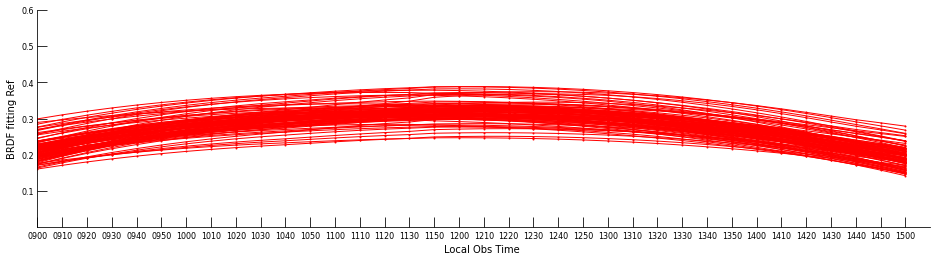

In [425]:
axis_min = 0
axis_max = 0.6

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(111)


ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

# ax1.plot(label,X,color = 'k',marker="o",markersize=1,linewidth=1,label='Ref')
for i in range(2*r):
    for j in range(2*r):
        ax1.plot(label,Y[:,i,j],color = 'r',marker="o",markersize=1,linewidth=1,label='{},{}'.format(i,j))


# ax1.set_xticks(np.linspace(0,105,106))
ax1.set_yticks(np.arange(axis_min+0.1,1.1,0.1))

ax1.set_xlabel("Local Obs Time ",fontsize=10)
ax1.set_ylabel("BRDF fitting Ref",fontsize=10)



text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22

ax1.set_xlim(axis_min,36)
ax1.set_ylim(axis_min,axis_max)
# plt.legend()

In [382]:
from sklearn.metrics import r2_score,mean_squared_error
def add_right_cax(ax, pad, width):

    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax
def identifer(li):
    result = []
    for a in li:
        mean = np.nanmean(a)
        std = np.nanstd(a) 
        down = mean - 3 * std
        up =  mean + 3 * std
        n_a = np.where(a < down,np.nan,a)
        n_a = np.where(n_a > up,np.nan,n_a)
        result.append(n_a)
    return result

In [ ]:
np.array(Ref).shape

In [ ]:
DAY = 2

X = np.array(Ref)[0:35,:,:]
Y = fiso[:,:] + np.array(kvol)[0:35,:,:]*fvol[:,:] + np.array(kgeo)[0:35,:,:]*fgeo[:,:]

nan_mask = ~np.isnan(X.reshape(-1))
X = X.reshape(-1)[nan_mask]
Y = Y.reshape(-1)[nan_mask]

nan_mask = ~np.isnan(Y.reshape(-1))
X = X.reshape(-1)[nan_mask]
Y = Y.reshape(-1)[nan_mask]


# rmse = np.sqrt(mean_squared_error(X ,Y))
p = np.polyfit(X ,Y,1)    

k = round(p[0],2)
b = round(p[1],2)
rmse = round(rmse.astype('float64'),3)

axis_min = 0
axis_max = 1

fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111,aspect='equal')

x = np.arange(axis_min,axis_max+1)
y = 1 * x

xx = np.arange(0,1+0.1,0.05) 
yy = k * xx + b

# Calculate the point density
xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
X, Y, z = X[idx], Y[idx], z[idx]

ax1.minorticks_on()
# x_major_locator = plt.MultipleLocator(5)
x_minor_locator = plt.MultipleLocator(0.05)
ax1.xaxis.set_minor_locator(x_minor_locator)
# ax.xaxis.set_major_locator(x_major_locator)
ax1.yaxis.set_minor_locator(x_minor_locator)
# ax.yaxis.set_major_locator(x_major_locator)

ax1.tick_params(axis="y",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)

ax1.tick_params(axis="x",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')


im = ax1.scatter(X,Y,marker='o', c=z,s=15,cmap='Spectral_r')
# im = ax1.scatter(X,Y,marker='o', c='k',s=15)

ax1.set_xticks(np.arange(axis_min,axis_max+0.1,0.1))
ax1.set_yticks(np.arange(axis_min+0.1,axis_max+0.1,0.1))

ax1.set_xlabel("AHI Ref ",fontsize=10)
ax1.set_ylabel("BRDF fitting Ref",fontsize=10)


ax1.plot(x,y,color='k',linewidth=2,linestyle='-',alpha=0.6)
ax1.plot(xx,yy,color='r',linewidth=2,linestyle='-') 


text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22

ax1.text(text_x,text_y,s = 'N = {}\nRMSE = {}\ny = {} + {}x'.format(len(X),rmse,b,k),fontsize=8)

cax = add_right_cax(ax1, pad=0.06, width=0.03)
cb = fig.colorbar(im,cax=cax)
cb.ax.set_xlabel('Count',rotation=360)
ax1.set_xlim(axis_min,axis_max)
ax1.set_ylim(axis_min,axis_max)

# Pandas

In [612]:
import pandas as pd

In [624]:
FISO = fiso.reshape(-1)[~np.isnan(fiso.reshape(-1))]

In [625]:
df = pd.DataFrame(FISO)
df.describe()

,0
count,21040.000000
mean,0.380917
std,32.345422
min,-1588.200322
25%,-0.096191
50%,0.193482
75%,0.594255
max,1221.407705


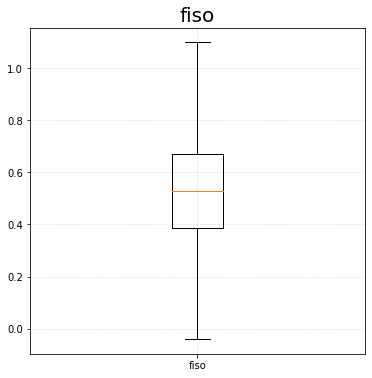

In [35]:
FISO = fiso.reshape(-1)[~np.isnan(fiso.reshape(-1))]
fig = plt.figure(figsize=(6,6))
plt.boxplot(FISO,showfliers = False,labels=['fiso'])
plt.title('fiso',fontsize = 20)
plt.grid(linestyle="--", alpha=0.3)
# plt.ylabel('atm – cm',fontsize = 12)
# plt.savefig('AOT550.jpg',dpi = 1000)
plt.show()

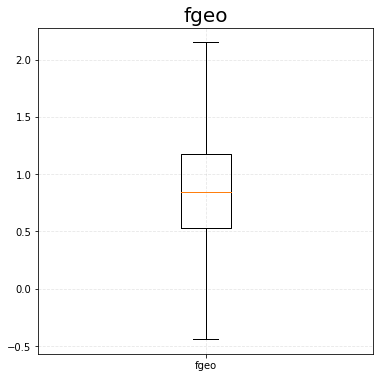

In [36]:
FGEO = fgeo.reshape(-1)[~np.isnan(fgeo.reshape(-1))]
fig = plt.figure(figsize=(6,6))
plt.boxplot(FGEO,showfliers = False,labels=['fgeo'])
plt.title('fgeo',fontsize = 20)
plt.grid(linestyle="--", alpha=0.3)
# plt.ylabel('atm – cm',fontsize = 12)
# plt.savefig('AOT550.jpg',dpi = 1000)
plt.show()

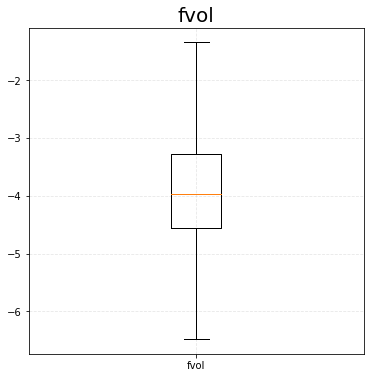

In [37]:
FVOL = fvol.reshape(-1)[~np.isnan(fvol.reshape(-1))]
fig = plt.figure(figsize=(6,6))
plt.boxplot(FVOL,showfliers = False,labels=['fvol'])
plt.title('fvol',fontsize = 20)
plt.grid(linestyle="--", alpha=0.3)
# plt.ylabel('atm – cm',fontsize = 12)
# plt.savefig('AOT550.jpg',dpi = 1000)
plt.show()

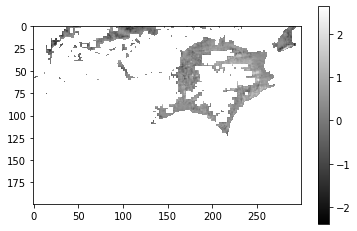

In [13]:
plt.imshow(fgeo,interpolation=None,cmap='gray')
plt.colorbar()

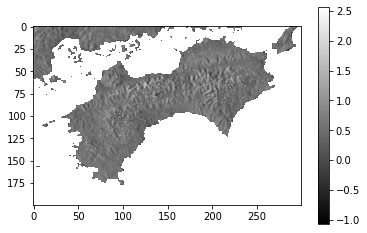

In [44]:
plt.imshow(fiso,interpolation=None,cmap='gray')
plt.colorbar()

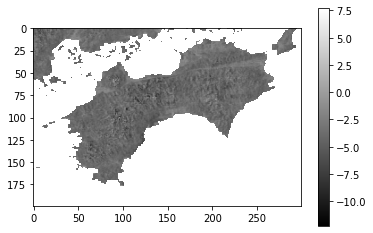

In [45]:
plt.imshow(fvol,interpolation=None,cmap='gray')
plt.colorbar()

In [92]:
date_start = '2018-07-22 09:00'
date_end = '2018-07-22 15:00'
date_t = dt.timedelta(minutes=10)
# date_t = dt.timedelta(minutes=30)
date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
date_time_now = date_s
label = []
while date_time_now <= date_e:
    # print(date_time_now)
    start_time = T.time()
    YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
    label.append(HH+MIN)
    date_time_now = date_time_now + date_t

In [93]:
del(label[16])

In [94]:
label

['0900',
 '0910',
 '0920',
 '0930',
 '0940',
 '0950',
 '1000',
 '1010',
 '1020',
 '1030',
 '1040',
 '1050',
 '1100',
 '1110',
 '1120',
 '1130',
 '1150',
 '1200',
 '1210',
 '1220',
 '1230',
 '1240',
 '1250',
 '1300',
 '1310',
 '1320',
 '1330',
 '1340',
 '1350',
 '1400',
 '1410',
 '1420',
 '1430',
 '1440',
 '1450',
 '1500']

# Read SGLI

In [421]:
import numpy as np
import math
import os
from osgeo import gdal
import xarray as xr
from skimage.measure import block_reduce
from ftplib import FTP
import subprocess
import rioxarray
import time as T
import datetime
import ephem
import numpy.ma as ma
import datetime as dt
from joblib import Parallel, delayed

def calc_sunpos(dtime,lat,lon):
    sun = ephem.Sun()
    obs = ephem.Observer()
    obs.date = dtime
    obs.lat = lat*math.pi/180.0
    obs.long = lon*math.pi/180.0
    sun.compute(obs)
    return np.degrees(sun.az),90.0-np.degrees(sun.alt)


class SGLI_L2_Downloader:
    
    def __init__ (self, User_ID , ProductName, Ver, Date , Tile , Obrit ,ParaVer, Target_path):
        self.User_ID = User_ID
        self.ProductName = ProductName
        self.Ver = Ver
        self.Date = Date
        self.Tile = Tile
        self.Obrit = Obrit
        self.ParaVer = ParaVer
        self.Target_path = Target_path
        
        
    def path (self):
        return '/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.{}/{}/{}/{}/{}'.format(self.ProductName, self.Ver, self.Date[0:4], self.Date[4:6], self.Date[6:8])

    def filename (self):
        return 'GC1SG1_{}{}01D_T{}_L2SG_{}Q_{}00{}.h5'.format(self.Date, self.Obrit, self.Tile, self.ProductName, self.Ver, self.ParaVer)
    
    def login (self):
        ftp_addr = 'ftp.gportal.jaxa.jp'
        f = FTP(ftp_addr)
        f.login(self.User_ID,'anonymous')
        
        return f
    
    def download (self, f):
        remote_filepath = self.path()
        f.cwd(remote_filepath)
        list=f.nlst()
        
        bufsize=1024
        if self.filename() in list:
            data = open ('{}{}'.format(self.Target_path, self.filename()), 'wb')
            filename = 'RETR ' + self.filename()
            f.retrbinary(filename,data.write,bufsize)
            return 'y'
        else:
            return 'n'
    
    def logout (self, f):
        f.quit()
    
def reporjection_GEO(filename,Band,Target_path):
    
    #print(path)
    p = subprocess.Popen('/data01/people/liwei/Data/GCOM-C_RSRF/SGLI_geo_map_linux.exe {} -d Geometry_data/{} -o {} -r 0 -s 30'.format(filename,Band,Target_path[:-1]),shell=True)
    p.communicate()
    # subprocess.check_output('/data01/people/liwei/Data/GCOM-C_RSRF/SGLI_geo_map_linux.exe {} -d Geometry_data/{} -o {} -s 7.5'.format(filename,Band,Target_path[:-1]), shell=True) 
    
def mkdir(path):
    folder = os.path.exists(path) 
    if not folder:
        os.makedirs(path)
        
    
def SGLI_2_AHI_GEO(filepath,lat,lon):  
    geotiff_da = rioxarray.open_rasterio(filepath)
    data = geotiff_da.interp(x=lon,y=lat,method="nearest")
    if data != -32768:
        data = data * 0.01
        return data
    else:
        return np.nan
def SGLI_2_AHI_TIME(filepath,lat,lon):
    geotiff_da = rioxarray.open_rasterio(filepath)
    data = geotiff_da.interp(x=lon,y=lat,method="nearest")
    if data != -32768.:
        data = data * 0.001
        return data
    else:
        return np.nan

def download_tile(date,save_tile_path,tile):
    g = SGLI_L2_Downloader(
        'galiwei ' ,
        'RSRF', 
        '3', 
         date , 
         tile, 
        'D' , 
        '1' ,
         save_tile_path
        )
    f = g.login()
    
    if os.path.exists(save_tile_path + g.filename()):
        return g.filename()
    
    else :
        rc = g.download(f)
        if rc == 'n':
            g.logout(f)
            return 'n'
        else:
            g.logout(f)
            return g.filename()
    

def Decompression(t,fn):
    if os.path.exists('{}.bz2'.format(t + fn)):
        p = subprocess.Popen('lbzip2 -d {}.bz2'.format(t + fn),shell=True)
        p.communicate()
        
def ahi_lon_timeoffset(lon): 
    lon_interval = 15 
    UTC_e_lon = lon_interval / 2 
    timeoffset = math.ceil((lon - UTC_e_lon) / lon_interval) 
    return timeoffset 
        
def Time_split(time):
    YYYY = time.strftime('%Y')
    MM = time.strftime('%m')
    DD = time.strftime('%d')
    HH = time.strftime('%H')
    MIN = time.strftime('%M')
    date = YYYY + MM + DD
    return YYYY,MM,DD,HH,MIN,date
    
    
def lonlat2tileidx(latlon:tuple)->tuple:
    # vertical pixel count in one tile, horizontal pixel count in one tile
    lintile, coltile = 1200, 1200
    # vertical tile count, horizontal tile count
    vtilenum, htilenum = 18, 36
    # [deg/pixel]
    d = 180.0/lintile/vtilenum
    # from S-pole to N-pole
    NL = 180.0/d
    NP0 = 2*np.round(180.0/d)
    res1 = (90 - latlon[0])/d-0.5
    V_idx = res1 // lintile
    # Y_idx = res1 - V_idx * lintile
    # GCOM-C use integer NPi
    NPi = round(NP0*np.cos(np.deg2rad(latlon[0])))
    res2 = latlon[1]*NPi/360 - 0.5 + NP0/2
    H_idx = res2 // coltile
    # X_idx = res2 - H_idx * coltile
    return str(round(V_idx)).rjust(2,'0')  + str(round(H_idx)).rjust(2,'0') 
def SGLI_SA(h,_min,lat,lon):

    d = datetime.datetime(int(YYYY),int(MM),int(DD),h,_min)
    
    SAA,SZA = calc_sunpos(d,lat,lon)
    return SAA,SZA
reporjection_file_path = '/data01/people/liwei/Data/GCOM-C_RSRF/reporjection/'
tile_file_path = '/data01/people/liwei/Data/GCOM-C_RSRF/tile/'

In [396]:
AHI_lat = np.linspace(60,-59.99,12000)[2550:2750][i_idx-r:i_idx+r]
AHI_lon = np.linspace(85,204.99,12000)[4700:5000][j_idx-r:j_idx+r]

In [212]:
import rioxarray
def SGLI_2_AHI_IMAGE(filepath,lat,lon):
    geotiff_da = rioxarray.open_rasterio(filepath)
    data = geotiff_da.interp(x=lon,y=lat,method="nearest")
    data = np.where(data != 65535, data ,np.nan)
    data = data * 0.0001
    return data

In [397]:
SGLI_VZA = []
SGLI_SZA = []
SGLI_RAA = []
SGLI_Ref = []
b = 'Rs_PI02'
for d in range(21,28):
    date_start = '2018-07-{} 00:00'.format(str(d))
    date_end = '2018-07-{} 06:00'.format(str(d))
    date_t = dt.timedelta(days=1)
    # date_t = dt.timedelta(minutes=30)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    b = 4
    
    c_SGLI_VZA = []
    c_SGLI_SZA = []
    c_SGLI_RAA = []
    c_SGLI_Ref = []
    # time_list = []
    while date_time_now <= date_e:
        print(date_time_now)
        start_time = T.time()
        YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
        for lat_idx in range(2*r):
            for lon_idx in range(2*r):

                # 获取该经纬度的Tile号
                # print(lat_idx,lon_idx) 

                tile = lonlat2tileidx([AHI_lat[lat_idx],AHI_lon[lon_idx]])

                # print(tile) 
                # SGLI 文件名
                SGLI_tile_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001.h5'.format(date,tile)
                SGLI_VZA_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Sensor_zenith_PL.tif'.format(date,tile)
                SGLI_VAA_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Sensor_azimuth_PL.tif'.format(date,tile)
                SGLI_TIME_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Obs_time_PL.tif'.format(date,tile)
                SGLI_REF_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Rs_PI02.tif'.format(date,tile)

                # 存在SGLI文件
                # print('1')
                if os.path.exists(reporjection_file_path + SGLI_VAA_filename) and os.path.exists(reporjection_file_path + SGLI_VZA_filename):
                    # print('1')
                    # 读取该像素经纬度SGLI的VZA和VAA
                    SGLI_VZA_PL = SGLI_2_AHI_GEO(reporjection_file_path + SGLI_VZA_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
                    SGLI_VAA_PL = SGLI_2_AHI_GEO(reporjection_file_path + SGLI_VAA_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])

                    if not np.isnan(SGLI_VZA_PL) and not np.isnan(SGLI_VAA_PL):
                        if SGLI_VAA_PL < 0:
                            SGLI_VAA_PL = SGLI_VAA_PL + 360
                    # 计算该像素经纬度SGLI的SZA和SAA

                        SGLI_Obs_TIME = SGLI_2_AHI_TIME(reporjection_file_path + SGLI_TIME_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
                        if not np.isnan(SGLI_Obs_TIME):
                            # print(SGLI_Obs_TIME)
                            SGLI_MIN = int(round(math.modf(SGLI_Obs_TIME)[0],3)*60)
                            SGLI_HH = int(math.modf(SGLI_Obs_TIME)[1])
                            if SGLI_HH <= 23 and SGLI_MIN >= 0 and SGLI_MIN <= 59:
                                SGLI_SAA_PL,SGLI_SZA_PL = SGLI_SA(SGLI_HH,SGLI_MIN,AHI_lat[lat_idx],AHI_lon[lon_idx])
                                SGLI_Ref_PL = SGLI_2_AHI_IMAGE(reporjection_file_path + SGLI_REF_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
                                # 读取AHI的SZA、SAA
                                SGLI_RAA_PL = abs(SGLI_SAA_PL - SGLI_VAA_PL.data[0])
                                c_SGLI_VZA.append(SGLI_VZA_PL.values[0])
                                c_SGLI_SZA.append(SGLI_SZA_PL)
                                c_SGLI_RAA.append(SGLI_RAA_PL)
                                c_SGLI_Ref.append(SGLI_Ref_PL)
        SGLI_VZA.append(np.array(c_SGLI_VZA))
        SGLI_SZA.append(np.array(c_SGLI_SZA))
        SGLI_RAA.append(np.array(c_SGLI_RAA))
        SGLI_Ref.append(np.array(c_SGLI_Ref))
        date_time_now = date_time_now + date_t                            

2018-07-21 00:00:00
2018-07-22 00:00:00
2018-07-23 00:00:00
2018-07-24 00:00:00
2018-07-25 00:00:00
2018-07-26 00:00:00
2018-07-27 00:00:00


In [432]:
VZA[i-r:i+r,j-r:j+r] 

array([[41.09, 41.09, 41.09, 41.09, 41.08, 41.08, 41.08, 41.08, 41.07,
        41.07],
       [41.08, 41.08, 41.08, 41.08, 41.07, 41.07, 41.07, 41.07, 41.06,
        41.06],
       [41.07, 41.07, 41.07, 41.06, 41.06, 41.06, 41.06, 41.05, 41.05,
        41.05],
       [41.06, 41.06, 41.06, 41.05, 41.05, 41.05, 41.05, 41.04, 41.04,
        41.04],
       [41.05, 41.05, 41.05, 41.04, 41.04, 41.04, 41.04, 41.03, 41.03,
        41.03],
       [41.04, 41.04, 41.03, 41.03, 41.03, 41.03, 41.02, 41.02, 41.02,
        41.02],
       [41.03, 41.03, 41.02, 41.02, 41.02, 41.02, 41.01, 41.01, 41.01,
        41.01],
       [41.02, 41.01, 41.01, 41.01, 41.01, 41.01, 41.  , 41.  , 41.  ,
        41.  ],
       [41.01, 41.  , 41.  , 41.  , 41.  , 40.99, 40.99, 40.99, 40.99,
        40.98],
       [41.  , 40.99, 40.99, 40.99, 40.99, 40.98, 40.98, 40.98, 40.98,
        40.97]])

In [400]:

def SGLI_Kernel_BRDF(band,day,idx_row,idx_col): 
    if band == 3:
        if SGLI_SZA[day].size != 0:
            kvol = Volume_Kernel(640,AHI_lat[idx_row],AHI_lon[idx_col],MJD,np.cos(np.radians(SGLI_SZA[day].reshape(2*r,2*r)[idx_row,idx_col])),np.cos(np.radians(SGLI_VZA[day].reshape(2*r,2*r)[idx_row,idx_col])),np.cos(np.radians(SGLI_RAA[day].reshape(2*r,2*r)[idx_row,idx_col])))
            kgeo = Geometric_Kernel(640,AHI_lat[idx_row],AHI_lon[idx_col],MJD,np.cos(np.radians(SGLI_SZA[day].reshape(2*r,2*r)[idx_row,idx_col])),np.cos(np.radians(SGLI_VZA[day].reshape(2*r,2*r)[idx_row,idx_col])),np.cos(np.radians(SGLI_RAA[day].reshape(2*r,2*r)[idx_row,idx_col])))
            return kvol,kgeo
        else:
            return np.nan,np.nan
    elif band == 4:
        if SGLI_SZA[day].size != 0:
            kvol = Volume_Kernel(860,AHI_lat[idx_row],AHI_lon[idx_col],MJD,np.cos(np.radians(SGLI_SZA[day].reshape(2*r,2*r)[idx_row,idx_col])),np.cos(np.radians(SGLI_VZA[day].reshape(2*r,2*r)[idx_row,idx_col])),np.cos(np.radians(SGLI_RAA[day].reshape(2*r,2*r)[idx_row,idx_col])))
            kgeo = Geometric_Kernel(860,AHI_lat[idx_row],AHI_lon[idx_col],MJD,np.cos(np.radians(SGLI_SZA[day].reshape(2*r,2*r)[idx_row,idx_col])),np.cos(np.radians(SGLI_VZA[day].reshape(2*r,2*r)[idx_row,idx_col])),np.cos(np.radians(SGLI_RAA[day].reshape(2*r,2*r)[idx_row,idx_col])))
            return kvol,kgeo
        else:
            return np.nan,np.nan

In [401]:
band = 4
Kresult = Parallel(n_jobs=10)(delayed(SGLI_Kernel_BRDF)(b,d,i,j) for d in range(7) for i in range(2*r) for j in range(2*r))
SGLI_kvol = np.array(Kresult)[:,0].reshape(7,2*r,2*r)
SGLI_kgeo = np.array(Kresult)[:,1].reshape(7,2*r,2*r)

In [403]:
i,j = 79,190
# X_SGLI = np.array(Ref_valid)[0:36,i-6:i+6,j-6:j+6]
Y_SGLI = fiso[i-r:i+r,j-r:j+r] + np.array(SGLI_kvol)[:,:,:]*fvol[i-r:i+r,j-r:j+r] + np.array(SGLI_kgeo)[:,:,:]*fgeo[i-r:i+r,j-r:j+r]

In [417]:
XX = []
YY = []
for i in range(7):
    if SGLI_SZA[i].size != 0:
        XX.append(SGLI_Ref[i].reshape(2*r,2*r).tolist())
        YY.append(Y_SGLI[i].reshape(2*r,2*r).tolist())

In [414]:
XX = SGLI_Ref[day].reshape(6,6)
YY = Y_SGLI[day]

ValueError: cannot reshape array of size 0 into shape (6,6)

(0.0, 0.5)

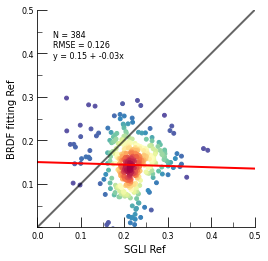

In [420]:
day = 6

XX = np.array(XX).reshape(-1)
YY = np.array(YY).reshape(-1)
# XX = SGLI_Ref[day].reshape(-1)
# YY = Y_SGLI[day].reshape(-1)
nan_mask = ~np.isnan(YY.reshape(-1))
XX = XX.reshape(-1)[nan_mask]
YY = YY.reshape(-1)[nan_mask]

rmse = np.sqrt(mean_squared_error(XX ,YY))
p = np.polyfit(XX ,YY,1)    

k = round(p[0],2)
b = round(p[1],2)
rmse = round(rmse.astype('float64'),3)


axis_min = 0
axis_max = 0.5

fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111,aspect='equal')

x = np.arange(axis_min,axis_max+1)
y = 1 * x

xx = np.arange(0,1+0.1,0.05) 
yy = k * xx + b

# Calculate the point density
xy = np.vstack([XX,YY])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
XX, YY, z = XX[idx], YY[idx], z[idx]

ax1.minorticks_on()
# x_major_locator = plt.MultipleLocator(5)
x_minor_locator = plt.MultipleLocator(0.05)
ax1.xaxis.set_minor_locator(x_minor_locator)
# ax.xaxis.set_major_locator(x_major_locator)
ax1.yaxis.set_minor_locator(x_minor_locator)
# ax.yaxis.set_major_locator(x_major_locator)

ax1.tick_params(axis="y",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)

ax1.tick_params(axis="x",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')


im = ax1.scatter((XX*1.002)-0.03456,YY,marker='o', c=z,s=15,cmap='Spectral_r')
# im = ax1.scatter(XX,YY,marker='o', c='k',s=15)

ax1.set_xticks(np.arange(axis_min,axis_max+0.1,0.1))
ax1.set_yticks(np.arange(axis_min+0.1,axis_max+0.1,0.1))

ax1.set_xlabel("SGLI Ref ",fontsize=10)
ax1.set_ylabel("BRDF fitting Ref",fontsize=10)


ax1.plot(x,y,color='k',linewidth=2,linestyle='-',alpha=0.6)
ax1.plot(xx,yy,color='r',linewidth=2,linestyle='-') 


text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22

ax1.text(text_x,text_y,s = 'N = {}\nRMSE = {}\ny = {} + {}x'.format(len(XX),rmse,b,k),fontsize=8)
# cax = add_right_cax(ax1, pad=0.06, width=0.03)
# cb = fig.colorbar(im,cax=cax)
# cb.ax.set_xlabel('Count',rotation=360)

ax1.set_xlim(axis_min,axis_max)
ax1.set_ylim(axis_min,axis_max)

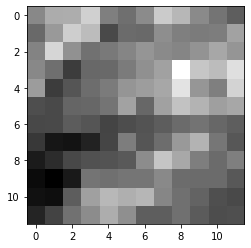

In [312]:
plt.imshow(SGLI_Ref[3].reshape(12,12),cmap='gray')

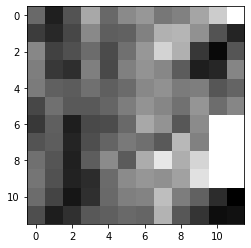

In [313]:
plt.imshow(Y_SGLI[3].reshape(12,12),cmap='gray')